In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rich import print
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error

import joblib

import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

## Model Pipeline


Recap on preprocessing/feature engineering done:

- Ordinal encoding
- Scale numerical data
- drop uninformative features
- principle component analysis
- KMeans clustering
- Target encoding
- One-hot encoding
- feature creationdd


Can now build a variety of regression models useful for predicting house prices

## Load data


In [12]:
# load data
dir = Path().resolve().parents[0] / "data" / "final"

In [13]:
train_path = dir / "fin_train.pkl"
test_path = dir / "fin_test.pkl"

train_df = pd.read_pickle(train_path)
X_test = pd.read_pickle(test_path)

In [14]:
train_df.head(2)

,LotFrontage,LotArea,LotShape,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SalePrice,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSZoning_C (all),MSZoning_FV,MSZoning_RL,MSZoning_RM,Alley_Grvl,LandContour_Bnk,LandContour_HLS,LotConfig_CulDSac,Condition1_Artery,Condition1_Feedr,Condition1_Norm,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_CompShg,Exterior1st_AsbShng,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasA,Heating_Grav,Heating_Wall,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Shed,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,PC1,cluster,GrLivArea,GarageAreaPerCar,BathBedroomRatio,TotalSF,TotalPorchSF,HasFireplace,HasGarage,HasFinBsmt,HasBsmt,Has2ndFloor
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,3.0,-0.211518,6.0,4.0,1.050994,0.878668,0.143911,0.514104,2.0,4.0,2.0,4.0,3.0,2.0,0.575425,6.0,-0.944591,-0.459303,0.0,1.0,5.0,-0.793434,1.161852,1.107810,0.789741,1.227585,0.163779,-0.211454,2.0,0.912210,-0.951226,3.0,1.017598,2.0,0.311725,0.351000,5.0,5.0,2.0,-0.752176,0.216503,-0.359325,-0.270208,4.0,208500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.50523,4,0.370333,1.125995,4.821985,-0.090885,-1.281545,0,1,1,0,1
2,0.460320,-0.091886,3.0,-0.278367,5.0,7.0,0.156734,-0.429577,-0.323985,-0.570750,3.0,4.0,2.0,4.0,1.0,0.0,1.171992,6.0,-0.641228,0.466465,0.0,1.0,5.0,0.257140,-0.795163,-0.819964,0.789741,-0.761621,0.163779,-0.211454,3.0,-0.318683,0.600495,5.0,-0.107927,2.0,0.311725,-0.060731,5.0,5.0,2.0,1.626195,-0.704483,-0.359325,-0.270208,4.0,181500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.35290,0,-0.482512,-0.194823,4.821985,-0.071558,0.175839,1,0,1,1,0


In [15]:
train_df.shape

(1460, 116)

In [16]:
# split data
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"].copy()
y = np.log1p(y)

In [17]:
train_cols = X.columns.tolist()
test_cols = X_test.columns.tolist()


train_col_drop = [col for col in train_cols if col not in test_cols]
test_col_drop = [col for col in test_cols if col not in train_cols]

X = X.drop(columns=train_col_drop)
X_test = X_test.drop(columns=test_col_drop)

## Model comparison pipeline


Create functions that will help evaluate the our models:
- use K-Fold cross validation 
- score each model using RMSLE
- visualise and contrast each model's performance across each K-Fold

In [18]:
def cross_val_model(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42).get_n_splits(X.values)
    scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    scores = np.sqrt(scores)

    print(
        f"RMSLE: {scores}\n Mean: {scores.mean()}\n Standard deviation: {scores.std()}"
    )

    return scores.mean(), scores

In [19]:
def model_eval_pipeline(model_pipe, X, y):
    model_mean_scores = []
    model_scores = []

    for name, model in model_pipe:
        print(f"Cross-validating {name}")

        # return RMSLE scores
        mean_score, scores = cross_val_model(model, X, y)

        # append results
        model_mean_scores.append(mean_score)
        model_scores.append({name: scores})

    # get the best model
    smallest_score = min(model_mean_scores)
    index_pos = model_mean_scores.index(smallest_score)
    model = model_pipe[index_pos]

    print(f"Best model: {model[0]} with RMSLE: {smallest_score}")

    return model[1], model_scores

Build each model

In [20]:
gbr = GradientBoostingRegressor(random_state=42, loss="huber")
kr = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))
xgb = XGBRegressor(random_state=42)
hgb = HistGradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)


stack = StackingRegressor(
    estimators=[
        ("gbr", gbr),
        ("kr", kr),
        ("lasso", lasso),
        ("xgb", xgb),
        ("hgb", hgb),
        ("rf", rf),
    ],
    final_estimator=gbr,
    cv=5,
    n_jobs=-1,
)

The code below takes each model and runs them through the evaluation functions above, allowing us to quickly evaluate the performance of each model before progressing to hyperparameter tuning.

In [21]:
model_names = [
    "Gradient Boosting Regressor",
    "Random Forest Regressor",
    "Hist Gradient Boosting Regressor",
    "XGBoost Regressor",
    "Kernel Ridge Regressor",
    "Lasso Regressor",
]

models = [
    gbr,
    rf,
    hgb,
    xgb,
    kr,
    lasso
]

model_pipe = list(zip(model_names, models))

best_model, model_scores = model_eval_pipeline(model_pipe, X, y)

# output best model
joblib.dump(best_model, Path().cwd().parent / "models" / "base" / "gbr_best_model.pkl")

best_model

Cross-validating Gradient Boosting Regressor

RMSLE: [0.11346894 0.133038   0.1330266  0.1213705  0.13055129]
 Mean: 0.1262910656986566
 Standard deviation: 0.007715659447351792

Cross-validating Random Forest Regressor

RMSLE: [0.12919123 0.16273213 0.15243105 0.13946905 0.13577579]
 Mean: 0.14391985044633387
 Standard deviation: 0.012078162271353495

Cross-validating Hist Gradient Boosting Regressor

RMSLE: [0.11652389 0.13953163 0.13649091 0.1252672  0.12980942]
 Mean: 0.12952460987994038
 Standard deviation: 0.008196282211622628

Cross-validating XGBoost Regressor

RMSLE: [0.12648446 0.15705607 0.14869465 0.13077287 0.14617368]
 Mean: 0.14183634684066973
 Standard deviation: 0.011450500821032135

Cross-validating Kernel Ridge Regressor

RMSLE: [0.11375664 0.15019529 0.12715359 0.10910467 0.12283158]
 Mean: 0.12460835502856855
 Standard deviation: 0.014300004364349401

Cross-validating Lasso Regressor

RMSLE: [0.11782731 0.14984727 0.13200223 0.12051656 0.19119049]
 Mean: 0.14227677238516842
 Standard deviation: 0.02693218557874874

Best model: Kernel Ridge Regressor with RMSLE: 0.12460835502856855

KernelRidge(alpha=0.6, coef0=2.5, degree=2, kernel='polynomial')

Model rankings based on average RMSLE score:
- Gradient Boosting 
- Hist Gradient Boosting 
- Kernel Ridge 
- XGBoost
- Random Forest
- Lasso

In [22]:
def model_comp_plot(data: list[dict[str, int]]) -> None:
    """Plot the model performance for each K-fold.

    Args:
        data (list[dict[str, int]]): list containing MAE scores for each K-fold
    """
    # unpack model scores
    scores = {list(item.keys())[0]: item[list(item.keys())[0]] for item in data}

    # Create a Pandas DataFrame
    df = pd.DataFrame(scores)
    df["K-fold"] = df.index + 1
    df = df.melt(id_vars=["K-fold"], var_name="Model", value_name="RMSLE")

    # plot
    sns.lineplot(data=df, x="K-fold", y="RMSLE", hue="Model")
    plt.title("RMSLE for each K-fold - Model Comparison")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

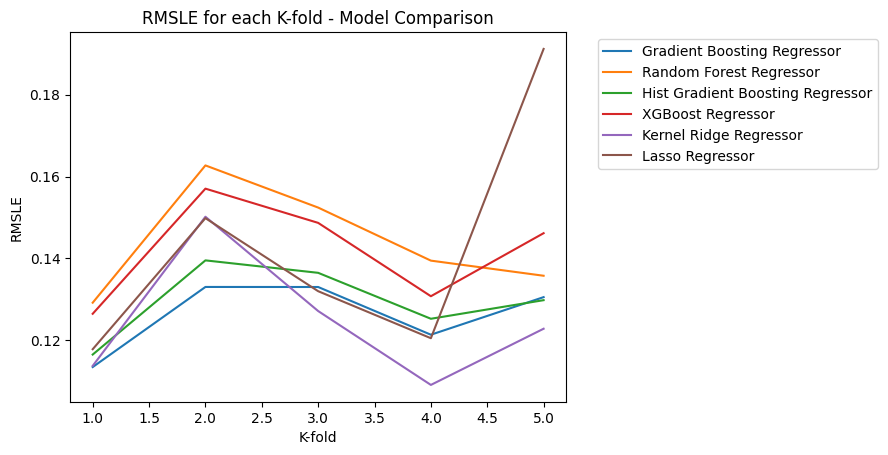

In [23]:
model_comp_plot(model_scores)

In [48]:
def random_search_tuning(model, params, X, y):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=100,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.cv_results_

In [26]:
def hyperparameter_tuning_results(cv_results: dict[str, np.ndarray]) -> list:
    return [
        (-mean_score, params)
        for mean_score, params in zip(
            cv_results["mean_test_score"], cv_results["params"]
        )
    ]

In [59]:
gbr_params = {
    'n_estimators': stats.randint(100, 500),  # Number of boosting stages
    'learning_rate': stats.uniform(0.01, 0.3),  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': stats.randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': stats.randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'subsample': stats.uniform(0.5, 0.5),  # Subsample ratio of the training instance
}

kr_params = {
    'alpha': stats.uniform(0.1, 10),  # Regularization parameter
    'kernel': ['linear', 'polynomial'],  # Kernel type
    'gamma': stats.uniform(0.1, 1)  # Kernel coefficient for 'rbf' and 'polynomial'
}

xgb_params = {
    'n_estimators': stats.randint(50, 200),  # Number of boosting rounds
    'max_depth': stats.randint(3, 10),  # Maximum depth of a tree
    'learning_rate': stats.uniform(0.01, 0.3),  # Learning rate
    'subsample': stats.uniform(0.5, 0.5),  # Subsample ratio of the training instance
    'colsample_bytree': stats.uniform(0.5, 0.5),  # Subsample ratio of columns when constructing each tree
    'gamma': stats.uniform(0, 1),  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': stats.uniform(0, 1),  # L1 regularization term on weights
    'reg_lambda': stats.uniform(0, 1)  # L2 regularization term on weights
}

rf_params = {
    'n_estimators': stats.randint(50, 200),  # Number of trees in the forest
    'max_depth': [None] + list(stats.randint(5, 50).rvs(10)),  # Maximum depth of the tree
    'min_samples_split': stats.randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': stats.randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

lasso_params = {
    'lasso__alpha': stats.uniform(0.01, 10),  # Regularization strength
    'lasso__tol': stats.uniform(1e-5, 1e-2),  # Tolerance for stopping criteria
    'lasso__max_iter': [1000],  # Maximum number of iterations
    'lasso__selection': ['cyclic', 'random']  # Method used to select features
}

hgb_params = {
    'learning_rate': stats.uniform(0.01, 0.3),  # Learning rate
    'max_iter': stats.randint(50, 200),  # Maximum number of iterations
    'max_depth': [3, 4, 5, 6, None],  # Maximum depth of the individual regression estimators
    'min_samples_leaf': stats.randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'l2_regularization': stats.uniform(0, 1)  # L2 regularization term on weights
}


In [86]:
model_dir = Path().cwd().parent / "models" / "tuned"

In [56]:
best_gbr, cv_results = random_search_tuning(gbr, gbr_params, X, y)

joblib.dump(best_gbr, model_dir / "gbr_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"Gradient boosting tuning: \n{rmsle_scores}")

Gradient boosting tuning: 
[(nan, {'learning_rate': 0.1396064657093627, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 11, 
'min_samples_split': 10, 'n_estimators': 85, 'subsample': 0.5260466644138093}), (nan, {'learning_rate': 
0.09555844622432803, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 14, 
'n_estimators': 118, 'subsample': 0.7560654592105011}), (nan, {'learning_rate': 0.30499306741381094, 'max_depth': 
3, 'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 14, 'n_estimators': 121, 'subsample': 
0.6187165537577286}), (nan, {'learning_rate': 0.21452877183499386, 'max_depth': 3, 'max_features': 'auto', 
'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 152, 'subsample': 0.8016365919371015}), (nan, 
{'learning_rate': 0.08412420574777008, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 16, 
'min_samples_split': 5, 'n_estimators': 197, 'subsample': 0.8476898180478449}), (nan, {'learning_rate': 
0.06426603026334349, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 10, 
'n_estimators': 158, 'subsample': 0.851824720532464}), (0.019218102439160535, {'learning_rate': 
0.05218804619033686, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 15, 
'n_estimators': 65, 'subsample': 0.834868283333528}), (0.029122860122142817, {'learning_rate': 
0.030710089024540088, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 11, 'min_samples_split': 16, 
'n_estimators': 57, 'subsample': 0.5735065741788743}), (nan, {'learning_rate': 0.246278286737381, 'max_depth': 3, 
'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 162, 'subsample': 
0.5197222749852588}), (nan, {'learning_rate': 0.10341078527029596, 'max_depth': 5, 'max_features': 'auto', 
'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 90, 'subsample': 0.887830186301172}), 
(0.01680541538836538, {'learning_rate': 0.02320054268409051, 'max_depth': 6, 'max_features': 'sqrt', 
'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 181, 'subsample': 0.5934018680785347}), (nan, 
{'learning_rate': 0.02135547364604983, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 18, 
'min_samples_split': 19, 'n_estimators': 135, 'subsample': 0.533221054213706}), (0.017283199391877606, 
{'learning_rate': 0.02347521566668216, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 14, 
'min_samples_split': 14, 'n_estimators': 186, 'subsample': 0.7555704221247702}), (0.019705620143383763, 
{'learning_rate': 0.07234310058952845, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 15, 
'min_samples_split': 8, 'n_estimators': 51, 'subsample': 0.7978681124348244}), (nan, {'learning_rate': 
0.2559778177927734, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 15, 
'n_estimators': 121, 'subsample': 0.9526993347626777}), (nan, {'learning_rate': 0.07555450594246195, 'max_depth': 
4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 64, 'subsample': 
0.9036122712550675}), (0.01794556755630572, {'learning_rate': 0.25956530795574584, 'max_depth': 4, 'max_features': 
'sqrt', 'min_samples_leaf': 19, 'min_samples_split': 4, 'n_estimators': 111, 'subsample': 0.7049380551685963}), 
(nan, {'learning_rate': 0.0596185791192189, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 17, 
'min_samples_split': 3, 'n_estimators': 83, 'subsample': 0.7778089107536112}), (0.015988842330233413, 
{'learning_rate': 0.15968855417498148, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 
'min_samples_split': 17, 'n_estimators': 147, 'subsample': 0.861403757435809}), (nan, {'learning_rate': 
0.07773352768633564, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 3, 
'n_estimators': 118, 'subsample': 0.5836267945000114}), (0.0195727654778177, {'learning_rate': 0.220

In [60]:
best_kr, cv_results = random_search_tuning(kr, kr_params, X, y)

joblib.dump(best_kr, model_dir / "kr_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"Kernel Ridge tuning: \n{rmsle_scores}")

Kernel Ridge tuning: 
[(0.1020302325967474, {'alpha': 1.5357481695592545, 'gamma': 0.6960412609001363, 'kernel': 'polynomial'}), 
(0.09798195402984253, {'alpha': 7.057026881352749, 'gamma': 0.20434800353693153, 'kernel': 'linear'}), 
(0.06127397333997915, {'alpha': 2.673647884539858, 'gamma': 1.0550861641944826, 'kernel': 'linear'}), 
(0.06797977201839804, {'alpha': 3.3264720687227, 'gamma': 0.15121088606951852, 'kernel': 'linear'}), 
(0.07624844977183963, {'alpha': 6.3287125573400855, 'gamma': 0.4123582926143453, 'kernel': 'polynomial'}), 
(0.08580667140586354, {'alpha': 2.9494745064860384, 'gamma': 0.5034535400720888, 'kernel': 'polynomial'}), 
(0.10432658664866065, {'alpha': 8.051245851143129, 'gamma': 0.8207002375929705, 'kernel': 'polynomial'}), 
(0.07041115397360173, {'alpha': 3.5791726453709996, 'gamma': 0.6745760074560506, 'kernel': 'linear'}), 
(0.11363955906603496, {'alpha': 6.251657912717215, 'gamma': 0.9996298981377731, 'kernel': 'polynomial'}), 
(0.10306106997357148, {'alpha': 7.828459332194893, 'gamma': 0.8753947414827633, 'kernel': 'linear'}), 
(0.09823513419415164, {'alpha': 5.138530593722233, 'gamma': 0.6956890016169958, 'kernel': 'polynomial'}), 
(0.11358350358151643, {'alpha': 9.570203748630407, 'gamma': 0.45505545498770505, 'kernel': 'linear'}), 
(0.11297511366310023, {'alpha': 9.464006635911298, 'gamma': 0.739063204713333, 'kernel': 'linear'}), 
(0.0456363623389854, {'alpha': 7.720558825054919, 'gamma': 0.13806709627428218, 'kernel': 'polynomial'}), 
(0.09218460845589761, {'alpha': 6.228629396327075, 'gamma': 0.33366171295139135, 'kernel': 'linear'}), 
(0.10921460790092344, {'alpha': 5.88906962421475, 'gamma': 0.9001318245528562, 'kernel': 'polynomial'}), 
(0.10625566625553592, {'alpha': 0.4630237633960709, 'gamma': 0.7037117931611705, 'kernel': 'polynomial'}), 
(0.05221445710512372, {'alpha': 1.8958144720380887, 'gamma': 0.3062497181023618, 'kernel': 'linear'}), 
(0.11472219470434279, {'alpha': 5.285718528581354, 'gamma': 1.012896768885096, 'kernel': 'polynomial'}), 
(0.10606400422114523, {'alpha': 1.7387744824113394, 'gamma': 0.7691706829781846, 'kernel': 'polynomial'}), 
(0.09655188754566929, {'alpha': 8.095808128544919, 'gamma': 0.6857512657065001, 'kernel': 'polynomial'}), 
(0.11905003742633455, {'alpha': 0.24316451333008074, 'gamma': 0.9168502813444265, 'kernel': 'polynomial'}), 
(0.0754037562837194, {'alpha': 7.536861874225208, 'gamma': 0.4036744942513605, 'kernel': 'polynomial'}), 
(0.07462280755310288, {'alpha': 4.845147119868322, 'gamma': 0.3920881243655452, 'kernel': 'polynomial'}), 
(0.07378382925329852, {'alpha': 7.683830891593185, 'gamma': 0.3859105475935918, 'kernel': 'polynomial'}), 
(0.07375719445255034, {'alpha': 3.940855390016329, 'gamma': 0.8872698754225816, 'kernel': 'linear'}), 
(0.10541182965684819, {'alpha': 9.809953333181019, 'gamma': 0.8502801941949223, 'kernel': 'polynomial'}), 
(0.06069739302694884, {'alpha': 2.620554234283985, 'gamma': 0.542673424313552, 'kernel': 'linear'}), 
(0.03451057380993167, {'alpha': 0.7241381594246631, 'gamma': 0.15699650706026838, 'kernel': 'linear'}), 
(0.10834508898378217, {'alpha': 8.678219305451963, 'gamma': 0.8674366199881324, 'kernel': 'linear'}), 
(0.1121893541946688, {'alpha': 9.327871515096271, 'gamma': 0.8003855234900966, 'kernel': 'linear'}), 
(0.059446193028645365, {'alpha': 2.5070047219485505, 'gamma': 0.4595054943158946, 'kernel': 'linear'}), 
(0.10228870620514294, {'alpha': 2.9196795321365343, 'gamma': 0.7338524996265118, 'kernel': 'polynomial'}), 
(0.1186594383604711, {'alpha': 4.680160541894021, 'gamma': 1.099202260214296, 'kernel': 'polynomial'}), 
(0.05814648988287572, {'alpha': 9.788117925482306, 'gamma': 0.2289557076253436, 'kernel': 'polynomial'}), 
(0.056686834710252196, {'alpha': 2.6502475742759777, 'gamma': 0.2254356210125902, 'kernel': 'polynomial'}), 
(0.05527638361565755, {'alpha': 2.1451506620893226, 'gamma': 0.17921895682801484, 'kernel': 'linear'}), 
(0.05663885450854145, {'alpha': 2.260569676958284, 'gamma': 0.143271620

In [61]:
best_xgb, cv_results = random_search_tuning(xgb, xgb_params, X, y)

joblib.dump(best_xgb, model_dir / "xgb_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"XGBoost tuning: \n{rmsle_scores}")

XGBoost tuning: 
[(0.02075316286732101, {'colsample_bytree': 0.9006096740039586, 'gamma': 0.43869625127414646, 'learning_rate': 
0.2628890019411045, 'max_depth': 9, 'n_estimators': 135, 'reg_alpha': 0.7051595150308253, 'reg_lambda': 
0.5875012827052702, 'subsample': 0.6586518657568782}), (0.020988589431660244, {'colsample_bytree': 
0.7534432727896434, 'gamma': 0.39942504623325126, 'learning_rate': 0.2670290497154619, 'max_depth': 4, 
'n_estimators': 153, 'reg_alpha': 0.5196294910540811, 'reg_lambda': 0.6684619449118798, 'subsample': 
0.5165080055431259}), (0.022987929843144884, {'colsample_bytree': 0.6845092232478289, 'gamma': 0.928245140731337, 
'learning_rate': 0.2370903940159855, 'max_depth': 8, 'n_estimators': 144, 'reg_alpha': 0.23100324167418007, 
'reg_lambda': 0.7556160541096573, 'subsample': 0.5619250076104851}), (0.018334654881981848, {'colsample_bytree': 
0.6985015639252665, 'gamma': 0.17343536167476625, 'learning_rate': 0.1253903718532109, 'max_depth': 4, 
'n_estimators': 63, 'reg_alpha': 0.5413581706611436, 'reg_lambda': 0.792495397858244, 'subsample': 
0.869393392690216}), (0.019086832331230714, {'colsample_bytree': 0.9296050622856078, 'gamma': 0.2734971997598111, 
'learning_rate': 0.06593459226157801, 'max_depth': 3, 'n_estimators': 131, 'reg_alpha': 0.3384190850421921, 
'reg_lambda': 0.043976398517284965, 'subsample': 0.9673687029648581}), (0.022766252241169287, {'colsample_bytree': 
0.7972750420775809, 'gamma': 0.6207893511449035, 'learning_rate': 0.28596721375815, 'max_depth': 8, 'n_estimators':
66, 'reg_alpha': 0.6278995452402629, 'reg_lambda': 0.12422914255807782, 'subsample': 0.7131085054118629}), 
(0.020885596271954725, {'colsample_bytree': 0.9995473475353676, 'gamma': 0.502977026567123, 'learning_rate': 
0.22535647078438859, 'max_depth': 4, 'n_estimators': 172, 'reg_alpha': 0.11029739880436473, 'reg_lambda': 
0.3113479557054314, 'subsample': 0.6244425208187027}), (0.02211833772001332, {'colsample_bytree': 
0.5315661406267875, 'gamma': 0.6916162577771767, 'learning_rate': 0.12732157676536585, 'max_depth': 8, 
'n_estimators': 123, 'reg_alpha': 0.9769041679816878, 'reg_lambda': 0.23480636011109302, 'subsample': 
0.8417139093837109}), (0.021294846215607892, {'colsample_bytree': 0.8162045307791553, 'gamma': 0.6019676714750187, 
'learning_rate': 0.1407576397470969, 'max_depth': 7, 'n_estimators': 60, 'reg_alpha': 0.2951507995335241, 
'reg_lambda': 0.41585411548532547, 'subsample': 0.7535139790969424}), (0.020722383869549173, {'colsample_bytree': 
0.7498080243632161, 'gamma': 0.4034026882657742, 'learning_rate': 0.29127095903936706, 'max_depth': 6, 
'n_estimators': 153, 'reg_alpha': 0.36355770922620945, 'reg_lambda': 0.5453501208112852, 'subsample': 
0.7269844859262279}), (0.0470068818241698, {'colsample_bytree': 0.6843594742744068, 'gamma': 0.03050810319857311, 
'learning_rate': 0.01809084657620818, 'max_depth': 6, 'n_estimators': 56, 'reg_alpha': 0.7603876356389867, 
'reg_lambda': 0.1773541726163238, 'subsample': 0.8779600954973326}), (0.02101757561270658, {'colsample_bytree': 
0.5475236682367799, 'gamma': 0.405113347365332, 'learning_rate': 0.0316924758511512, 'max_depth': 4, 
'n_estimators': 140, 'reg_alpha': 0.5268820172682003, 'reg_lambda': 0.13980125420039857, 'subsample': 
0.5069800280705782}), (0.021474971485801266, {'colsample_bytree': 0.7030630542565388, 'gamma': 0.5580889254114368, 
'learning_rate': 0.1497734992559225, 'max_depth': 4, 'n_estimators': 53, 'reg_alpha': 0.6393369734376488, 
'reg_lambda': 0.9889281669319947, 'subsample': 0.944941401814426}), (0.016999447898575555, {'colsample_bytree': 
0.8119973536829335, 'gamma': 0.07898550262190773, 'learning_rate': 0.10083882740469152, 'max_depth': 6, 
'n_estimators': 181, 'reg_alpha': 0.025960014691038036, 'reg_lambda': 0.10432326988254037, 'subsample': 
0.5905156246018771}), (0.023750976588427054, {'colsample_bytree': 0.8494665528414367, 'gamma': 0.7713620612936021, 
'learning_rate': 0.026073973949323308, 'max_depth': 6, 'n_estimators': 142, 'reg_al

In [49]:
best_hgb, cv_results = random_search_tuning(hgb, hgb_params, X, y)

joblib.dump(best_hgb, model_dir / "hgb_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"Hist Gradient Boosting tuning: \n{rmsle_scores}")

Hist Gradient Boosting tuning: 
[(0.0165898256400365, {'l2_regularization': 0.992809370880362, 'learning_rate': 0.25335609765248707, 'max_depth': 
3, 'max_iter': 186, 'min_samples_leaf': 19}), (0.016791764261185373, {'l2_regularization': 0.8227983110421826, 
'learning_rate': 0.05371100713906656, 'max_depth': 6, 'max_iter': 175, 'min_samples_leaf': 13}), 
(0.01846272444186118, {'l2_regularization': 0.7265170935263782, 'learning_rate': 0.24475525057811595, 'max_depth': 
None, 'max_iter': 74, 'min_samples_leaf': 9}), (0.01699023747342672, {'l2_regularization': 0.31442393503925026, 
'learning_rate': 0.20074789548823566, 'max_depth': 6, 'max_iter': 51, 'min_samples_leaf': 18}), 
(0.01599129289841151, {'l2_regularization': 0.8922958538894517, 'learning_rate': 0.16382414755402616, 'max_depth': 
4, 'max_iter': 125, 'min_samples_leaf': 14}), (0.01547274194808452, {'l2_regularization': 0.43014953794202926, 
'learning_rate': 0.05607411565159828, 'max_depth': 4, 'max_iter': 196, 'min_samples_leaf': 2}), 
(0.01698278048668539, {'l2_regularization': 0.38774743129455, 'learning_rate': 0.17375208451064306, 'max_depth': 5,
'max_iter': 188, 'min_samples_leaf': 12}), (0.016460579920067202, {'l2_regularization': 0.31442204447146926, 
'learning_rate': 0.11780232053372779, 'max_depth': 6, 'max_iter': 108, 'min_samples_leaf': 19}), 
(0.020142146543164714, {'l2_regularization': 0.3721674057332198, 'learning_rate': 0.01307156505885281, 'max_depth':
None, 'max_iter': 191, 'min_samples_leaf': 5}), (0.02174329689306704, {'l2_regularization': 0.7118614427307542, 
'learning_rate': 0.0371314839569455, 'max_depth': 3, 'max_iter': 80, 'min_samples_leaf': 12}), 
(0.015803694368622112, {'l2_regularization': 0.9426891417511744, 'learning_rate': 0.05354312300062547, 'max_depth':
4, 'max_iter': 150, 'min_samples_leaf': 4}), (0.019456978395381783, {'l2_regularization': 0.7131167998395369, 
'learning_rate': 0.2952658457556676, 'max_depth': None, 'max_iter': 136, 'min_samples_leaf': 13}), 
(0.017556940343108472, {'l2_regularization': 0.3021425695092168, 'learning_rate': 0.15751480382041128, 'max_depth':
None, 'max_iter': 198, 'min_samples_leaf': 9}), (0.01781766571618133, {'l2_regularization': 0.052691400406957745, 
'learning_rate': 0.25288629140505053, 'max_depth': 5, 'max_iter': 105, 'min_samples_leaf': 11}), 
(0.017323119091989653, {'l2_regularization': 0.15569594589432068, 'learning_rate': 0.04063468478488621, 
'max_depth': 6, 'max_iter': 120, 'min_samples_leaf': 13}), (0.01689337631202787, {'l2_regularization': 
0.8405058841425762, 'learning_rate': 0.039584774251116985, 'max_depth': 5, 'max_iter': 120, 'min_samples_leaf': 
7}), (0.016673297502089877, {'l2_regularization': 0.6247680384068716, 'learning_rate': 0.042013395890537014, 
'max_depth': None, 'max_iter': 181, 'min_samples_leaf': 19}), (0.017068961324801298, {'l2_regularization': 
0.6610745397282823, 'learning_rate': 0.28356265214187837, 'max_depth': 6, 'max_iter': 96, 'min_samples_leaf': 6}), 
(0.022352511455403103, {'l2_regularization': 0.7642784856615757, 'learning_rate': 0.02630636107002672, 'max_depth':
4, 'max_iter': 91, 'min_samples_leaf': 15}), (0.01750335091443148, {'l2_regularization': 0.5986504667659744, 
'learning_rate': 0.21809455607713582, 'max_depth': 6, 'max_iter': 147, 'min_samples_leaf': 8}), 
(0.016876142617660482, {'l2_regularization': 0.67630842668523, 'learning_rate': 0.09354915139544556, 'max_depth': 
6, 'max_iter': 66, 'min_samples_leaf': 8}), (0.016334596904493837, {'l2_regularization': 0.19911935372171086, 
'learning_rate': 0.08474033185483992, 'max_depth': 5, 'max_iter': 102, 'min_samples_leaf': 17}), 
(0.016386481401472017, {'l2_regularization': 0.4811506961872416, 'learning_rate': 0.20742423845993144, 'max_depth':
3, 'max_iter': 73, 'min_samples_leaf': 5}), (0.016911433982429176, {'l2_regularization': 0.8501484945341795, 
'learning_rate': 0.09371882848245146, 'max_depth': None, 'max_iter': 68, 'min_samples_leaf': 5}), 
(0.01732504295240707, {'l2_regularization': 0.8031812626498

In [50]:
best_rf, cv_results = random_search_tuning(rf, rf_params, X, y)

joblib.dump(best_rf, model_dir / "rf_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"Random Forest tuning: \n{rmsle_scores}")

Random Forest tuning: 
[(nan, {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split':
2, 'n_estimators': 125}), (nan, {'bootstrap': True, 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 9,
'min_samples_split': 15, 'n_estimators': 195}), (0.025713631514690433, {'bootstrap': True, 'max_depth': 47, 
'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 11, 'n_estimators': 107}), (0.019558281418837,
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9, 
'n_estimators': 99}), (nan, {'bootstrap': True, 'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 18, 
'min_samples_split': 8, 'n_estimators': 131}), (nan, {'bootstrap': True, 'max_depth': None, 'max_features': 'auto',
'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 127}), (nan, {'bootstrap': False, 'max_depth': 23, 
'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 16, 'n_estimators': 151}), (nan, {'bootstrap':
False, 'max_depth': 42, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 17, 'n_estimators': 
172}), (nan, {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 14, 
'min_samples_split': 2, 'n_estimators': 104}), (0.021909403368158924, {'bootstrap': False, 'max_depth': 21, 
'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 69}), (0.020460832128498217,
{'bootstrap': False, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 
'n_estimators': 143}), (nan, {'bootstrap': True, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 
'min_samples_split': 13, 'n_estimators': 85}), (nan, {'bootstrap': True, 'max_depth': 11, 'max_features': 'auto', 
'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 59}), (0.02560742944559234, {'bootstrap': True, 
'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 5, 'n_estimators': 155}), 
(0.024221624226582028, {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 11, 
'min_samples_split': 13, 'n_estimators': 194}), (0.02585231083241842, {'bootstrap': True, 'max_depth': 11, 
'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 4, 'n_estimators': 89}), (nan, {'bootstrap': 
True, 'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 80}),
(0.024017846427417132, {'bootstrap': True, 'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 10, 
'min_samples_split': 16, 'n_estimators': 149}), (0.024957098230982334, {'bootstrap': True, 'max_depth': 10, 
'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 14, 'n_estimators': 154}), 
(0.023234608009729638, {'bootstrap': True, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 7, 
'min_samples_split': 19, 'n_estimators': 168}), (0.022002935459361137, {'bootstrap': False, 'max_depth': 24, 
'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 11, 'n_estimators': 170}), (nan, {'bootstrap': 
False, 'max_depth': 42, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 
121}), (0.02364920257193514, {'bootstrap': True, 'max_depth': 37, 'max_features': 'sqrt', 'min_samples_leaf': 8, 
'min_samples_split': 15, 'n_estimators': 67}), (0.021392756138089906, {'bootstrap': False, 'max_depth': 11, 
'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 127}), (nan, {'bootstrap': 
True, 'max_depth': 37, 'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 14, 'n_estimators': 
166}), (0.026170600822493444, {'bootstrap': True, 'max_depth': 42, 'max_features': 'sqrt', 'min_samples_leaf': 16, 
'min_samples_split': 11, 'n_estimators': 133}), (0.02462813714516605, {'bootstrap': False, 'max_depth': 47, 
'max_features': 'sqrt', 'min_samples_leaf': 18, 'min_sam

In [53]:
best_lasso, cv_results = random_search_tuning(lasso, lasso_params, X, y)

joblib.dump(best_lasso, model_dir / "lasso_tuned_model.pkl")

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(f"Lasso tuning: \n{rmsle_scores}")

Lasso tuning: 
[(0.15963491063269095, {'lasso__alpha': 1.1528837248549983, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 
'lasso__tol': 0.009320163913909059}), (0.15963491063269095, {'lasso__alpha': 8.902319467425533, 'lasso__max_iter': 
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0027340914953587936}), (0.15963491063269095, {'lasso__alpha': 
8.801684526514501, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 'lasso__tol': 0.004045171760331768}), 
(0.15963491063269095, {'lasso__alpha': 7.320884614953966, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 
'lasso__tol': 0.005754076714779072}), (0.15963491063269095, {'lasso__alpha': 9.536158414348778, 'lasso__max_iter': 
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.008069574568565536}), (0.15963491063269095, {'lasso__alpha': 
8.432199646389968, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 'lasso__tol': 0.007804622972962831}), 
(0.15963491063269095, {'lasso__alpha': 1.6470330099170882, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 
'lasso__tol': 0.00821313208677497}), (0.15963491063269095, {'lasso__alpha': 5.752581154387812, 'lasso__max_iter': 
1000, 'lasso__selection': 'random', 'lasso__tol': 0.0025564356223274787}), (0.15963491063269095, {'lasso__alpha': 
3.5054024541792916, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 'lasso__tol': 0.008771805118672881}), 
(0.09460608089295897, {'lasso__alpha': 0.17336941457280375, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 
'lasso__tol': 0.008505149275958376}), (0.15963491063269095, {'lasso__alpha': 4.716121534611177, 'lasso__max_iter': 
1000, 'lasso__selection': 'random', 'lasso__tol': 0.0077195771601548625}), (0.15963491063269095, {'lasso__alpha': 
2.2982599022875982, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.00385761101700438}), 
(0.15963491063269095, {'lasso__alpha': 6.1929439043135055, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 
'lasso__tol': 0.008576879590646106}), (0.15963491063269095, {'lasso__alpha': 4.846535614680757, 'lasso__max_iter': 
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0018791580437209478}), (0.15963491063269095, {'lasso__alpha': 
8.391830317673, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.006221954595874601}), 
(0.15963491063269095, {'lasso__alpha': 5.369868418339879, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 
'lasso__tol': 0.006184309011680433}), (0.15963491063269095, {'lasso__alpha': 1.9966627534138581, 'lasso__max_iter':
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.004840012364456166}), (0.15963491063269095, {'lasso__alpha': 
4.219732556965667, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0021370487880921665}), 
(0.15963491063269095, {'lasso__alpha': 6.29584616762547, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 
'lasso__tol': 0.009248845967969658}), (0.15963491063269095, {'lasso__alpha': 6.5059115855939575, 'lasso__max_iter':
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.005970029859582909}), (0.15963491063269095, {'lasso__alpha': 
1.04142682551995, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 'lasso__tol': 6.413035547137014e-05}), 
(0.15963491063269095, {'lasso__alpha': 0.3770181017488139, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 
'lasso__tol': 0.004709874361346159}), (0.15963491063269095, {'lasso__alpha': 3.1071531042636575, 'lasso__max_iter':
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.009716892513443062}), (0.15963491063269095, {'lasso__alpha': 
7.2622037603583, 'lasso__max_iter': 1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.003112137110032176}), 
(0.15963491063269095, {'lasso__alpha': 8.498183936216716, 'lasso__max_iter': 1000, 'lasso__selection': 'random', 
'lasso__tol': 0.004870543522327597}), (0.15963491063269095, {'lasso__alpha': 1.4299604927801268, 'lasso__max_iter':
1000, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0028064251977563594}), (0.159634910632690

Cross-validate tuned models?

In [63]:
stacked_models = [
    ("gbr", best_gbr),
    ("kr", best_kr),
    ("lasso", best_lasso),
    ("xgb", best_xgb),
    ("hgb", best_hgb),
    ("rf", best_rf),
]

best_stack = StackingRegressor(
    estimators=stacked_models,
    final_estimator=best_gbr,
    cv=5,
    n_jobs=-1,
)

In [64]:
best_tuned, tuned_scores = model_eval_pipeline(
    [
        ("Gradient Boosting Regressor", best_gbr),
        ("Kernel Ridge Regressor", best_kr),
        ("XGBoost Regressor", best_xgb),
        ("Hist Gradient Boosting Regressor", best_hgb),
        ("Random Forest Regressor", best_rf),
        ("Lasso Regressor", best_lasso),
        ("Stacked Regressor", best_stack)
    ],
    X,
    y,
)

Cross-validating Gradient Boosting Regressor

RMSLE: [0.10860752 0.13401347 0.1282565  0.11438316 0.12295689]
 Mean: 0.12164350645321058
 Standard deviation: 0.00917738660474187

Cross-validating Kernel Ridge Regressor

RMSLE: [0.12741448 0.16801631 0.16157019 0.13473724 0.20309772]
 Mean: 0.15896718732378362
 Standard deviation: 0.02690290046816923

Cross-validating XGBoost Regressor

RMSLE: [0.10964979 0.13795111 0.1274243  0.11206521 0.12535093]
 Mean: 0.1224882675875115
 Standard deviation: 0.010441506583787868

Cross-validating Hist Gradient Boosting Regressor

RMSLE: [0.10789784 0.13826807 0.13351432 0.11581898 0.12394998]
 Mean: 0.12388983759036834
 Standard deviation: 0.01113777760222732

Cross-validating Random Forest Regressor

RMSLE: [0.12696903 0.15190981 0.14420284 0.1292316  0.13228813]
 Mean: 0.13692028339664503
 Standard deviation: 0.009563696499715777

Cross-validating Lasso Regressor

RMSLE: [0.14898053 0.17985064 0.16419643 0.15107193 0.20153806]
 Mean: 0.16912751781553856
 Standard deviation: 0.01960433366264982

Cross-validating Stacked Regressor

RMSLE: [0.10984705 0.12796627 0.12896308 0.11108895 0.13226265]
 Mean: 0.12202559947230211
 Standard deviation: 0.009551385677470476

Best model: Gradient Boosting Regressor with RMSLE: 0.12164350645321058

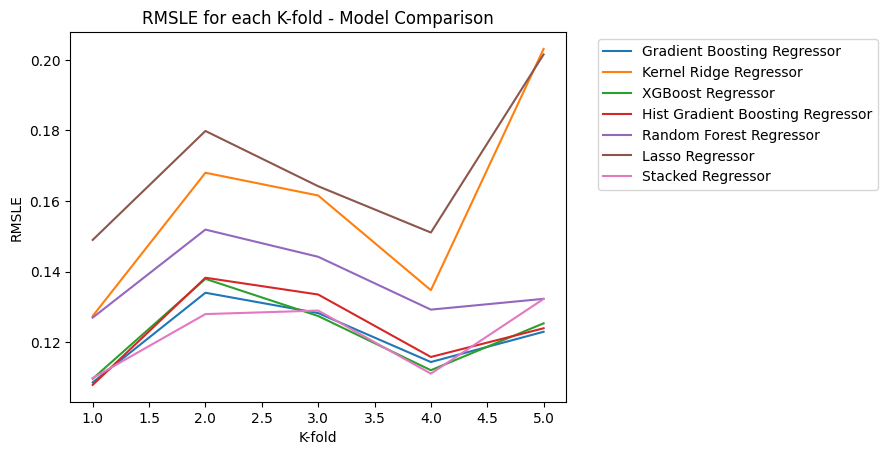

In [85]:
model_comp_plot(tuned_scores)

## Blend models together

fit each model

In [72]:
gbr_model = best_gbr.fit(X, y)
kr_model = kr.fit(X, y)
xgb_model = best_xgb.fit(X, y)
hgb_model = best_hgb.fit(X, y)
rf_model = best_rf.fit(X, y)
lasso_model = lasso.fit(X, y)
stacked_model = best_stack.fit(X, y) 

blend models - assign weighting to each model based on their performance

In [98]:
def blended_pred(X: pd.DataFrame):
    return (
        0.25 * gbr_model.predict(X)
        + 0.10 * kr_model.predict(X)
        + 0.15 * xgb_model.predict(X)
        + 0.20 * hgb_model.predict(X)
        + 0.05 * rf_model.predict(X)
        + 0.05 * lasso_model.predict(X)
        + 0.20 * stacked_model.predict(X)
    )

In [88]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [99]:
blended_score = rmsle(y, blended_pred(X))

print(f"Blended model RMSLE: {blended_score}")

Blended model RMSLE: 0.06382007706137745

## Predict on test data

In [100]:
y_pred = np.floor(np.expm1(blended_pred(X_test)))

In [101]:
blended_output = pd.DataFrame({"Id": X_test.index, "SalePrice": y_pred})

In [102]:
output_path = Path().cwd().parent / "output" / "blended_results.csv"
blended_output.to_csv(output_path, index=False)

## Feature Importances


In [103]:
feature_importance = best_gbr.feature_importances_
importance_df = pd.DataFrame(
    {"features": X.columns, "importance": feature_importance}
).sort_values(by="importance", ascending=False)

In [104]:
importance_df

,features,importance
4,OverallQual,0.158075
3,Neighborhood,0.085067
108,TotalSF,0.081682
105,GrLivArea,0.074896
103,PC1,0.069636
...,...,...
88,Heating_GasA,0.000021
67,BldgType_Twnhs,0.000004
52,MSSubClass_180,0.000003
87,Foundation_Slab,0.000000


In [105]:
def feature_importance_plot(data: pd.DataFrame):
    # Creating a bar chart
    plt.figure(figsize=(6, 6))
    sns.barplot(x="importance", y="features", data=data[data["importance"] != 0])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.grid(axis="x")

    # Display the chart
    plt.show()

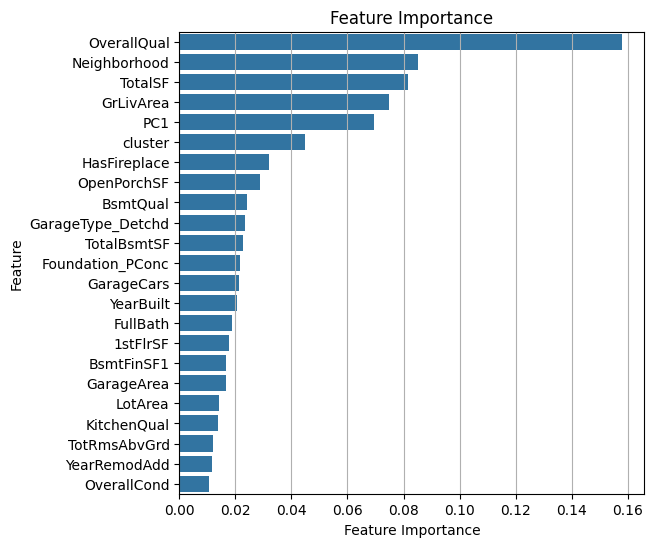

In [106]:
feature_importance_plot(importance_df.loc[importance_df["importance"] > 0.01])